**Differential privacy **
by Zofia Walczewska



**Goals of this notbook**
• We want to demonstrate an implementation the Privelet algorithm that perturbs a histogram while satisfying differential privacy.
• Further, we want to perform an experimental evaluation of our implementation.

**Introduction**
This notebook is a synthesis of the project's code and report including an anlysis to make the project more comprehensible for readers. Tip for readers: Start reading this notebook as a normal document. It's designed to work without a seperate readme file.   

In [1]:
#Setup
# the following contains the necessary libraries for this project
import pandas as pd
import matplotlib as plt
import numpy as np
import math
from scipy.stats import wasserstein_distance

**Data on which differential privacy needs to be achieved**
In this project we decided to use the adult data set (found here: https://archive.ics.uci.edu/ml/datasets/Adult ) to create a histogram of the education feature in the data set. We will use this data artefact to demonstrate how to achieve differential privacy.

**Data Mining and Preparation**
In the following we retrieve the adult data set and convert the column "education" into a histogram. See a representation of the histogram after the following code box (it is an array containing 16 values representing the frequency of the 16 distinct values in the education feature like "Bachelors" or "Some College").

In [2]:
#Preprocessing the data - build a histogram from the education column in the dataset
dataframe = pd.read_csv("/content/adult.data")
dataframe = pd.DataFrame(dataframe)
dataframe = dataframe.sort_values(by=['age'])

education_map = {"Bachelors": 1, "Some-college": 2, "11th": 3, "HS-grad": 4, 
                 "Prof-school": 5, "Assoc-acdm": 6, "Assoc-voc": 7, "9th": 8, 
                 "7th-8th": 9, "12th": 10, "Masters": 11,"1st-4th": 12, "10th": 
                 13, "Doctorate": 14, "5th-6th": 15, "Preschool": 16}
dataframe['education'] = dataframe['education'].map(education_map)

hist, bin_edges = np.histogram(dataframe["education"], bins = 16)
print(hist)

[ 5355  7291  1175 10501   576  1067  1382   514   646   433  1723   168
   933   413   333    51]


**Implementation of the 1-dimensional Privelet algorithm**

In the following we implement the Privelet algorithm described in the Section 4 “Privelet for one-dimensional ordinal data”. Throughout the rest of the notebook we will use the following reference so please refer to their work when you want to understand the theory in greater depth.
Reference: Xiaokui Xiao, Guozhang Wang, and Johannes Gehrke. “Differential Privacy via Wavelet Transforms”. In: IEEE
Trans. Knowl. Data Eng. 23.8 (2011), pp. 1200–1214. DOI: 10.1109/TKDE.2010.247. URL: https://doi.org/10.1109/TKDE.2010.247.

Our goal is to to construct this tree (Xiao et al. 2011) to perform a so called one-dimensional Haar wavelet transformation. Refer to section 3.1 of Xiao et al. 2011 to get a description of the privlet framework.

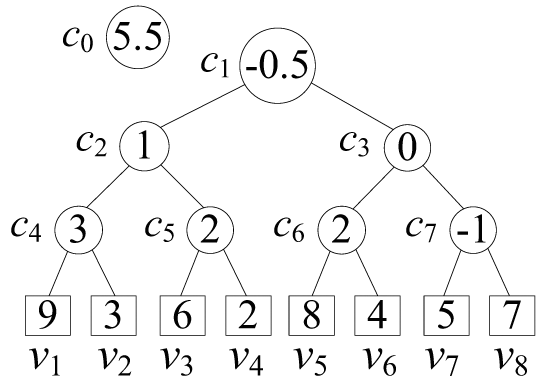

**Haar wavelet transformation procedure**

**1\) Tree construction** In order to construct the tree (R) of wavelet coeefictients we first construct a vector that contains the frequency of each bin where the bins are ordered. The bins in our case are the distinct education values and the value for each is the freuquency of occurance in the adult dataset.
When constructing the tree take the following into account: 

* The dimension of the vector is 2^l (if not we add '0' elements).
* Optionally we could use the histogram of any other feature of our dataset.
* How to get the input vector (leafs in the above tree): get all dinstinct values of the column and safe its frequency. Save fruequency by ordered distinct values (note in our case every distinct education value is associated with an unique integer value). 
* Depth of the binary tree is logarithm of M base 2. The number m of entries in M equals 2^l. Our dataset has 16 values so 2^4. so M = 16. Hence, we don't need to add '0' values. Consequently, the number of coefficients is 16 and the tree has depth of 4.
* Binary tree R with 16 leafs, where i-th leaf of R is equal to i-th entry in M
i is between 1 to 16 in our case.
* To calculate the wavelet coefficients in our tree we use: c=(a1−a2)/2.

In [3]:
'''
The function takes the histogram as input and outputs the coefficients of the tree
'''
def compute_wave(dataset,m):
  n = len(dataset)
  y = np.array(dataset)
  treeDepth = int(math.log(m,2))
  
  #sort the base of binary tree
  for i in range(0, len(y),2):
    elements = y[i:i+2][:2]
    if(elements[1] > elements[0]):
      a = elements[0]
      y[i:i+2][0] = y[i:i+2][1]
      y[i:i+2][1] = a
  dataset = y
  number_coefs = n
  #compute the coefficients
  v = 2
  coefficients = np.array([])
  for i in range(0, treeDepth): #tree starts at level 0 (in the image above that is the level with c4 c5 c6 c7)  
    for j in range(0, number_coefs, v):
      elements = y[j:j+v]
      coef = (np.mean(elements[0:v//2]) - np.mean(elements[v//2:v]))/2
      coefficients = np.append(coefficients, coef)
    v = v * 2
  coefficients = np.append(coefficients, np.mean(y))
  return (dataset, coefficients)

hist_sorted, coefficients = compute_wave(hist, 16)

**2) Adding random laplace noise to coefficients** In the following we add to each coefficient c a random Laplace noise with magnitude λ/WHaar(c), where WHaar is
a weight function (cf. Xiao et al. 2011 to read about details regarding the weight function): Here is what they write:
>>For the base coefficient
c, WHaar(c) = m; for a coefficient ci at level i of the decomposition tree, WHaar(ci) = 2^(l−i+1). For example, given thewavelet coefficients [see tree figure above], WHaar would assign weights
8, 8, 4, 2 to c0, c1, c2, and c4, respectively. 

View the output of the following code cell to see the coefficients with noise.

In [4]:
#lambda = sensitivity/epsilon
#sensitivity for us is 1- adding 1 person to the dataset will change the dataset by 1, so lambda = 1/epsilon.
#according to privelet algorithm, the magnitude has to be lambda/whaar.
'''
This function adds a random laplace noise to a given coefficient
'''
def laplaceMechanism(c, arguments):
  whaar = arguments[0] # whaar is a weight function
  epsilon = arguments[1]
  c +=  np.random.laplace(0, 1/epsilon*whaar, 1)[0]
  return c

'''
This function adds random laplace noise to every coefficient
'''
def add_random_noise_to_coefs(coefs, m, epsilon):
  treeDepth = int(math.log(m,2))
  # for us l = 4 because 2^4 = 16
  number_of_leafs = m//2
  level = 0
  #print(coefs)
  for i in range(0, treeDepth):
    whaar = 2 ** (1 + i)
    coefs[level:(level + number_of_leafs)] = np.apply_along_axis(laplaceMechanism,0, coefs[level:(level + number_of_leafs)], (whaar, epsilon))
    level = level + number_of_leafs    
    number_of_leafs = number_of_leafs // 2
  coefs[-1] = laplaceMechanism(coefs[-1], (m,epsilon))
  return coefs

coefficients = add_random_noise_to_coefs(coefficients, 16, 0.5)
print(coefficients)

[ 957.42380435 4652.42380435  234.92380435  423.42380435   95.92380435
  766.92380435  249.42380435  130.42380435  233.95176033  -71.79823967
 -211.54823967  231.95176033 2643.58854483  200.71354483 1520.34187616
 2058.17731359]


**3) Converting wavelet coefficients back to a noisy frequency matrix M\***

We just computed the noisy wavelet coefficients. In the following the Privelet converts them back to a noisy frequency matrix M∗ based on Equation 3 (cf. Xiao et al. 2011) and then terminates by returning M∗. See the following snippet from Xiao et al. 2011:
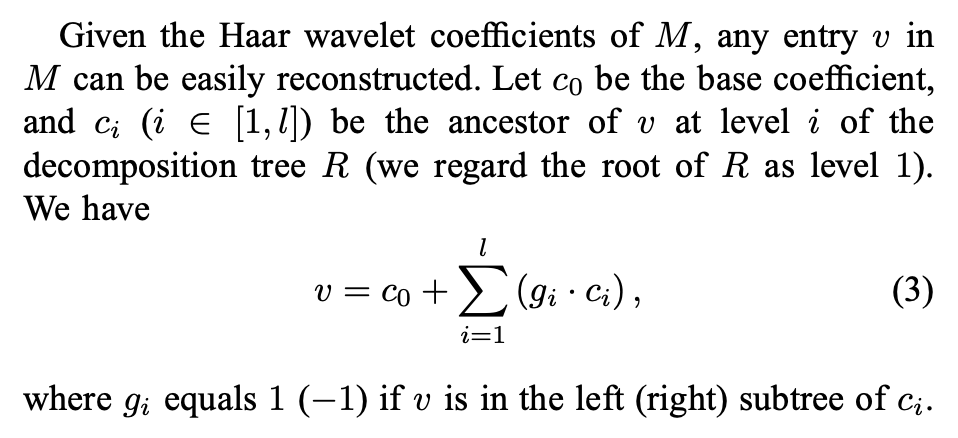

After the following code box you can compare the original sorted histogram and the perturbed one. You will see some (random!!) deviations in the frequencies of the bins. 

In [5]:
'''Since the number of distinct values in the education feature will NOT change, 
the decomposition tree will stay stable.
We therefor decided to go ahead with a hard coded solution to make the computations 
clear so the reader can easily develop an intuition for the computations
'''
def reconstruct_histogram(v):
  v1 = coefficients[0] + coefficients[8] + coefficients[12] + coefficients[14] + coefficients[15]
  v2 = - coefficients[0] + coefficients[8] + coefficients[12] + coefficients[14] + coefficients[15]
  v3 = coefficients[1] - coefficients[8] + coefficients[12] + coefficients[14] + coefficients[15]
  v4 = - coefficients[1] - coefficients[8] + coefficients[12] + coefficients[14] + coefficients[15]
  v5 = coefficients[2] + coefficients[9] - coefficients[12] + coefficients[14] + coefficients[15]
  v6 = - coefficients[2] + coefficients[9] - coefficients[12] + coefficients[14] + coefficients[15]
  v7 = coefficients[3] - coefficients[9] - coefficients[12] + coefficients[14] + coefficients[15]
  v8 = - coefficients[3] - coefficients[9] - coefficients[12] + coefficients[14] + coefficients[15]
  v9 = coefficients[4] + coefficients[10] + coefficients[13] - coefficients[14] + coefficients[15]
  v10 = - coefficients[4] + coefficients[10] + coefficients[13] - coefficients[14] + coefficients[15]
  v11 = coefficients[5] - coefficients[10] + coefficients[13] - coefficients[14] + coefficients[15]
  v12 = - coefficients[5] - coefficients[10] + coefficients[13] - coefficients[14] + coefficients[15]
  v13 = coefficients[6] + coefficients[11] - coefficients[13] - coefficients[14] + coefficients[15]
  v14 = - coefficients[6] + coefficients[11] - coefficients[13] - coefficients[14] + coefficients[15]
  v15 = coefficients[7] - coefficients[11] - coefficients[13] - coefficients[14] + coefficients[15]
  v16 = - coefficients[7] - coefficients[11] - coefficients[13] - coefficients[14] + coefficients[15]
  
  hist_perturbed = np.array([v1, v2, v3, v4, v5, v6, v7, v7, v8, v9, v10, v11, v12, v13, v14, v15, v16]).astype(int)

  return hist_perturbed

#print(hist_sorted)
reconstruct_histogram(coefficients)

array([ 7413,  5498, 10640,  1335,  1098,   628,  1430,  1430,   583,
         622,   431,  1717,   183,   818,   319,   235,   -25])

**Testing the code**

In the following we test our code with Privelet to compute the given histogram with **epsilon ∈ {0.01, 0.1, 1}** while all other parameters remain set to default. Hereby we demonstrate that with a smaller epsilon the perturbation increases. 

***epsilon = 0.01***

In [6]:
coefficients1 = add_random_noise_to_coefs(coefficients, 16, 0.01)
reconstructed_hist1 = reconstruct_histogram(coefficients)

***epsilon = 0.1***

In [7]:
coefficients2 = add_random_noise_to_coefs(coefficients, 16, 0.1)
reconstructed_hist2 = reconstruct_histogram(coefficients)

**epsilon = 1**

In [8]:
coefficients3 = add_random_noise_to_coefs(coefficients, 16, 1)
reconstructed_hist3 = reconstruct_histogram(coefficients)

**Study of the quality of Privelet on the histogram**

We consider the following epsilon values: epsilon ∈ {0.01, 0.1, 1, 10}.
Here's what we're going to do:
1. We compute the histogram on raw data without any noise.

In [9]:
theorical_results, coefficients = compute_wave(hist, 16)

2. We compute the histogram with different values of epsilon 20 times, and, each time, we measure the Wasserstein distance3 between the non-perturbed histogram and the freshly computed perturbed histogram.

***epsilon = 0.01***

In [10]:
print("wasserstein distance computed 20 times with epsilon=0.01" )
wasserstein_distance_001 = np.array([])
#We apply this algorithm 20 times with this value of epsilon to obtain an array of 20 different  wassertein distance.
for i in range(0,20,1):
  new_coefficients=add_random_noise_to_coefs(coefficients, 16, 0.01)
  reconstructed_hist = reconstruct_histogram(coefficients)
  y= wasserstein_distance(theorical_results, reconstructed_hist)
  wasserstein_distance_001 = np.append(wasserstein_distance_001, y)

print(wasserstein_distance_001)

wasserstein distance computed 20 times with epsilon=0.01
[ 3312.82720588  3431.0625      2619.46691176  4061.23897059
  8626.17279412  6288.17279412  8552.78308824  6377.29044118
  5564.70220588  5880.18014706  4405.87867647  2348.58455882
  3276.01838235  5331.65073529  6154.23897059  8187.13602941
  6085.18014706  6069.00367647  6585.00367647 11904.64338235]


***epsilon = 0.1***

In [11]:
print("wasserstein distance computed 20 times with epsilon=0.1" )
wasserstein_distance_01 = np.array([])
#We apply this algorithm 20 times with this value of epsilon to obtain an array of 20 different  wassertein distance.
for i in range(0,20,1):
  new_coefficients=add_random_noise_to_coefs(coefficients, 16, 0.1)
  reconstructed_hist = reconstruct_histogram(coefficients)
  y= wasserstein_distance(theorical_results, reconstructed_hist)
  wasserstein_distance_01 = np.append(wasserstein_distance_01, y)

print(wasserstein_distance_01)

wasserstein distance computed 20 times with epsilon=0.1
[11518.99632353 11343.58455882 11184.40808824 10906.34926471
 10906.29044118 10865.05514706 11169.87867647 11650.70220588
 12070.40808824 12317.9375     12374.99632353 12113.29044118
 11957.05514706 11735.11397059 11852.40808824 11686.58455882
 11735.29044118 11468.05514706 11599.29044118 11669.58455882]


***epsilon = 1***

In [12]:
print("wasserstein distance computed 20 times with epsilon=1" )
wasserstein_distance_1 = np.array([])
#We apply this algorithm 20 times with this value of epsilon to obtain an array of 20 different  wassertein distance.
for i in range(0,20,1):
  new_coefficients=add_random_noise_to_coefs(coefficients, 16, 1)
  reconstructed_hist = reconstruct_histogram(coefficients)
  y= wasserstein_distance(theorical_results, reconstructed_hist)
  wasserstein_distance_1 = np.append(wasserstein_distance_1, y)

print(wasserstein_distance_1)

wasserstein distance computed 20 times with epsilon=1
[11665.29044118 11610.9375     11606.46691176 11589.17279412
 11621.58455882 11552.34926471 11553.05514706 11520.05514706
 11545.34926471 11543.87867647 11564.70220588 11578.05514706
 11550.52573529 11539.52573529 11560.9375     11565.70220588
 11550.87867647 11550.64338235 11541.05514706 11526.99632353]


***epsilon = 10***

In [13]:
print("wasserstein_distance computed 20 times with epsilon=10" )
wasserstein_distance_10 = np.array([])
#We apply this algorithm 20 times with this value of epsilon to obtain an array of 20 different  wassertein distance.
for i in range(0,20,1):
  new_coefficients=add_random_noise_to_coefs(coefficients, 16, 10)
  reconstructed_hist = reconstruct_histogram(coefficients)
  y= wasserstein_distance(theorical_results, reconstructed_hist)
  wasserstein_distance_10 = np.append(wasserstein_distance_10, y)

print(wasserstein_distance_10)

wasserstein_distance computed 20 times with epsilon=10
[11525.40808824 11528.81985294 11528.34926471 11528.58455882
 11529.40808824 11530.46691176 11530.87867647 11529.99632353
 11530.11397059 11534.81985294 11534.87867647 11534.29044118
 11534.23161765 11532.9375     11533.9375     11536.70220588
 11536.29044118 11537.05514706 11536.46691176 11536.81985294]


3. We plot the average/min/max Wasserstein distances for each epsilon value. Hereby, the x-axis will be the epsilon values and the y-axis the average/min/max Wasserstein measures.

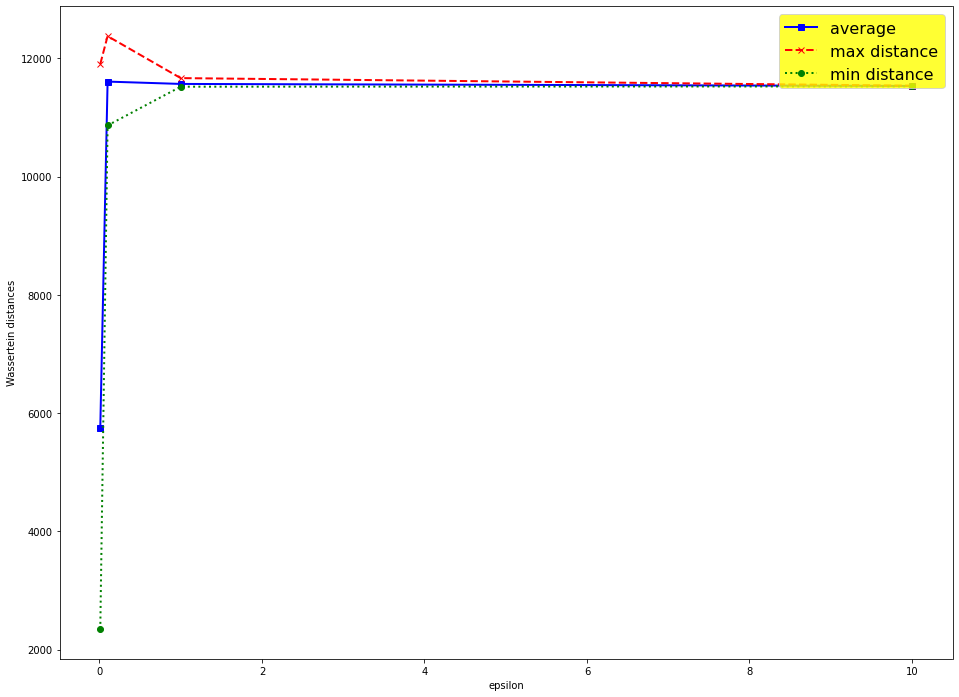

In [14]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(16,12))
all_wassertein= [wasserstein_distance_001,wasserstein_distance_01, wasserstein_distance_1, wasserstein_distance_10]
avg=np.array([])
max=np.array([])
min=np.array([])
epsilon= [0.01,0.1,1,10]
#We search the avg,max and min for every group of wassertein distances
for i in range(0,4,1):
  avg=np.append(avg,np.average(all_wassertein[i]))
  max=np.append(max,np.max(all_wassertein[i]))
  min=np.append(min,np.min(all_wassertein[i]))
variables=[avg,max,min]

#We plot everything in the same graph with different colors and lines
plt.plot(epsilon,avg, 's', color= 'blue',label='average', linestyle='solid', linewidth=2)
plt.plot(epsilon,max, 'x', color= 'red', label='max distance', linestyle='dashed', linewidth=2)
plt.plot(epsilon,min, 'o', color= 'green', label='min distance', linestyle='dotted', linewidth=2)
plt.xlabel('epsilon')
plt.ylabel('Wassertein distances')
plt.legend(loc='upper right', facecolor='yellow', fontsize=16)

Conclusion on the graph: We can observe in the the plot that the most appropriate epsilon has a value of 0.1.
* The values for episilon = 0.01 tend to deviate far from the average. This
makes that the maximum and minimum failures largly deviate from the mean. Moreover, the mean for epsilon = 0.01  usually has a significantly higher error than that for epsilon=0.1 which usually has the lowest mean failure in the plot.(This is not always true, since it is a random result applied only 20 times, there are occasions in which the mean of epsilon 0.01 has a lower error, but with a greater number of repetitions (more than 20) or representing the graph repeatedly we can see that epsilon 0.1 usually obtains better results).
* The results obtained with epsilon = 1 are significantly higher, and the deviation from the mean in that case is minimal.
* However for epsilon = 0.1 we can observe better mean values. From epsilon = 1 on, the model does not change (cf. results for epsilon = 10). Therefore, episilon values greater than 1 show similar effects on the data, and at some point the results are constant and do not depend on epsilon.
